<a href="https://colab.research.google.com/github/tdurand06/Solar-Fault-detection-CNN/blob/main/fault_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Introduction
This python script is a CNN classification machine learning project. The data contains 16 days of data of a grid-tie photovoltaic plant's operation with both faulty and normal operation.

The faults include:
1.	Short-Circuit (Short Circuit between 2 modules of a String)
2.	Degradation (There is a resistance between 2 modules of a String)
3.	Open Circuit (One String disconnected from the power inverter)
4.	Shadowing (Shadow in one or more modules).

The paper and results i am trying to reproduce can be found here:
https://www.mdpi.com/1424-8220/22/21/8515#B29-sensors-22-08515. This research achieved 97.64% accuracy.

The data source can be found:
https://github.com/clayton-h-costa/pv_fault_dataset

The data source origin is explained by this research group:
https://www.mdpi.com/1424-8220/20/17/4688

# Data

## Load data

In [ ]:
from scipy.io import loadmat
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from google.colab import drive
drive.mount('/content/drive')

drive_file_path1 = '/content/drive/MyDrive/Solar/dataset_amb.mat'
drive_file_path2 = '/content/drive/MyDrive/Solar/dataset_elec.mat'

amb_data = loadmat(drive_file_path1)
elec_data = loadmat(drive_file_path2)


Mounted at /content/drive


## Information from the data
First let's print some basic information about the data.

- The code below gets the information from the .mat data, mainly the keys, and the size of the dictionary it contains.
The values are bytes for the first three keys and then np arrays.
Let's look at it in more detail:


In [ ]:

# To get shape/size of .mat files:
print("Ambient data structure:", amb_data.keys())  # Shows all variables in the .mat file
print("Electric data structure:", elec_data.keys())

for key in elec_data.keys():
    if isinstance(elec_data[key], np.ndarray):
        print(f"{key}: shape = {elec_data[key].shape}")

Ambient data structure: dict_keys(['__header__', '__version__', '__globals__', 'f_nv', 'irr', 'pvt'])
Electric data structure: dict_keys(['__header__', '__version__', '__globals__', 'idc1', 'idc2', 'vdc1', 'vdc2'])
idc1: shape = (1, 1373798)
idc2: shape = (1, 1373798)
vdc1: shape = (1, 1373798)
vdc2: shape = (1, 1373798)


## Converting from scipy to pandas

The loadmat applied on .mat files results in a dictionary with variable names as keys and loaded matrices as values.
We therefore convert it first to a series to give us easy access to data cleaning functions from pandas like .drop.

- The elec pandas series from the elec .mat file looks like this:

```
__header__     b'MATLAB 5.0 MAT-file, Platform: PCWIN64, Crea...
__version__                                                  1.0
__globals__                                                   []
idc1           [[0.0608, 0.0615, 0.0646, 0.0628, 0.0606, 0.06...
idc2           [[0.0073, 0.0064, 0.0067, 0.0067, 0.0076, 0.00...
vdc1           [[0.7143, 0.6944, 0.711, 0.6991, 0.7035, 0.710...
vdc2           [[0.555, 0.5427, 0.5583, 0.5465, 0.5553, 0.549...
```


- The amb pandas series from the amb .mat file looks like:


```
__header__     b'MATLAB 5.0 MAT-file, Platform: PCWIN64, Crea...
__version__                                                  1.0
__globals__                                                   []
f_nv           [[0], [0], [0], [0], [0], [0], [0], [0], [0], ...
irr            [[1.3729, 1.3604, 1.5118, 1.5534, 1.4355, 1.36...
pvt            [[2.3816, 2.3816, 2.3883, 2.392, 2.392, 2.3913...
```

Notes on the code:
- .items() gives (index, value) pairs of a series.
- we use the [0] due to the double brackets found in the pandas series.

Notes on the data:

- irr and pvt are of shape:(1, 1373798)
- f_nv has shape (1373798, 1)

After having dropped the first three rows corresponding to loadmat metadata, we categorize the data from elec and from amb to X and y data.

In [ ]:

pd_elec_series=pd.Series(elec_data)
pd_elec_series = pd_elec_series.drop([pd_elec_series.index[0],pd_elec_series.index[1],pd_elec_series.index[2]], axis=0)
df_elec = pd.DataFrame({
    name: values[0] for name, values in pd_elec_series.items()
})

pd_amb_series = pd.Series(amb_data)

pd_amb_series = pd_amb_series.drop([pd_amb_series.index[0], pd_amb_series.index[1], pd_amb_series.index[2]])
def process_values(values):
    # If it's like irr or pvt ([[1.3729, 1.3604, ...]])
    if len(values[0]) > 1:
        return values[0]
    # If it's like f_nv ([[0], [0], [0], ...])
    else:
        return [val[0] for val in values]

df_amb = pd.DataFrame({
    name: process_values(values)
    for name, values in pd_amb_series.items()
})
X = pd.DataFrame({
    'idc1': df_elec['idc1'],
    'idc2': df_elec['idc2'],
    'vdc1': df_elec['vdc1'],
    'vdc2': df_elec['vdc2'],
    'irr': df_amb['irr'],
    'pvt': df_amb['pvt']
})
y = pd.DataFrame({
    'f_nv': df_amb['f_nv']
})

print(X.shape)
print(y.shape)


(1373798, 6)
(1373798, 1)


# Pytorch

We create a class called PVFaultDataset.

Normalizing and resampling data.

About DataLoader of PyTorch:
it is PyTorch's data handling system.
It allows:
- To iterate thru datasets in batches (useful for large datasets)
- shuffle the data before each epoch and sample data points to create mini-batches. Good for model efficiency
- They can use multiple worker processes to load data asynchronously in the background which speeds up complex data loading.

To use it you need:
- \_\_len\_\_ and \_\_getitem\_\_ that tells you how data is loaded.
NOT SURE IF THESE ARE SET CORRECTLY. MAKE SURE THEY ARE APPROPRIATE WITH THE SIZE OF MY TORCH TENSORS. MAYBE I NEED TO PASS THE TENSORS DIRECTLY AS ARGUMENTS  to PVFAULTDATASET?

- Create a DataLoader object


In [ ]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
import torch
import torch.nn as nn

class PVFaultDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32).unsqueeze(1)
        if isinstance(y, pd.DataFrame):
            y = y.values
        self.y = torch.tensor(y, dtype=torch.int64).squeeze()


    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

def preprocess_data(X, y):
    # Normalize data

    if isinstance(X, pd.DataFrame):
        X = X.values
    #Split in test/train

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

    scaler = StandardScaler()
    # transform X data into numpy array. Remember we are only doing this to X, not y
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Create datasets
    train_dataset = PVFaultDataset(X_train_scaled, y_train)
    test_dataset = PVFaultDataset(X_test_scaled, y_test)


    # Create data loaders
    train_loader = DataLoader(train_dataset, batch_size=32, num_workers=2, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=32, num_workers=2, shuffle=False)

    return train_loader, test_loader, scaler




CNN, notably conv1d expexcts an input of:
(N, Cin, L) where
- N = batch_size, Cin = # of observations/feature, L = # of features
- here, Cin =1 (Cin = 3 for RGB / pixel)
L = 6 features (L = # of pixels for a photo)
---
Currently, the X data is of size (batch size, 6).
So we need to transform it to (batch size, 1, 6) for it to be suitable for a pytorch CNN




So, before the unsqueeze(1), the format of a batch of size 2 was (2,6)

```
([[-0.6791, -0.6476, -0.9874, -0.9811, -0.7261, -0.7701],
        [ 0.0204, -0.5998,  1.1192,  1.4220,  0.2989, -0.1873],
```
But, with unsqueeze(1), the new size is: (2,1,6) and looks like
```
([[[-0.6973, -0.6555, -0.9842, -0.9796, -0.7256, -0.2878]],

        [[-0.6588, -0.6277,  0.8089,  0.9263, -0.6883, -0.2602]],

```
When you use `unsqueeze(1)`, it doesn't create "empty" space or None values - it actually broadcasts/replicates your original values into this new dimensional structure.

---
The new dimension doesn't contain new values - it's just a way of organizing the data. Think of it like this: if you had a single sheet of paper with numbers, unsqueeze is like putting that paper into a folder (adding a dimension). The numbers haven't changed, they're just organized in a new structure that the CNN expects.

---
I got these numbers by printing then.
For a batch size of 32, the number of batches, i.e. total_iteration is 34345. This is because 1099038/32 = 34344.9. So there are 34344 full batches and the last batch of 30 for a total of 34345.
and the number of iterations is:


# CNN
- Here is the CNN structure

In [ ]:

class PVFaultClassifier(nn.Module):
  def __init__(self):
    super(PVFaultClassifier, self).__init__()
    self.model = nn.Sequential(
        nn.Conv1d(in_channels=1, out_channels=16, kernel_size=3, stride=1, padding=1),
        nn.ReLU(),
        nn.MaxPool1d(kernel_size=2),
        nn.Conv1d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1),
        nn.ReLU(),
        nn.MaxPool1d(kernel_size=2),
        nn.Flatten(),
        nn.Linear(32, 64),
        nn.ReLU(),
        nn.Linear(64, 5)
    )

  def forward(self, x):
    return self.model(x)


## Supervised machine learning training pipeline
SGD training process:
- Zero out previous gradients (optimizer.zero_grad())
- Forward pass through the model (outputs = model(X_batch))
- Compute loss (loss = criterion(outputs, y_batch))
- Backward pass to compute gradients (loss.backward())
- Update model parameters (optimizer.step())

In [ ]:
def train_one_epoch(model, train_loader, criterion, optimizer):
    model.train()
    total_loss = 0
    correct = 0
    total = 0
    predictions = []
    targets = []

    for X_batch, y_batch in train_loader:
        # Move to GPU if available
        if torch.cuda.is_available():
            X_batch = X_batch.cuda()
            y_batch = y_batch.cuda()

        # Reshape labels from [batch_size, 1] to [batch_size]
        y_batch = y_batch.squeeze()

        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()

        # Calculate accuracy
        _, predicted = torch.max(outputs.data, 1)
        predictions.extend(predicted.cpu().numpy())
        targets.extend(y_batch.cpu().numpy())
        total += y_batch.size(0)
        correct += (predicted == y_batch).sum().item()

        total_loss += loss.item()

    return total_loss / len(train_loader), 100 * correct / total, predictions, targets

def validate(model, val_loader, criterion):
    model.eval()
    total_loss = 0
    correct = 0
    total = 0
    predictions = []
    targets = []

    with torch.no_grad():  # No gradients needed for validation
        for X_batch, y_batch in val_loader:
            if torch.cuda.is_available():
                X_batch = X_batch.cuda()
                y_batch = y_batch.cuda()

            y_batch = y_batch.squeeze()
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            #this is equivalent to finding the argmax of softmax probabilities
            _, predicted = torch.max(outputs.data, 1)
            predictions.extend(predicted.cpu().numpy())
            targets.extend(y_batch.cpu().numpy())
            total += y_batch.size(0)
            correct += (predicted == y_batch).sum().item()

            total_loss += loss.item()

    return total_loss / len(val_loader), 100 * correct / total, predictions, targets


def train_model(model, train_loader, test_loader, criterion, optimizer, num_epochs):
    best_val_loss = float('inf')
    patience = 10  # Early stopping patience
    patience_counter = 0

    # Lists to store metrics for plotting
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []

    # Training loop
    for epoch in range(num_epochs):
        # Train
        train_loss, train_acc, pred_train, target_train = train_one_epoch(model, train_loader, criterion, optimizer)

        # Validate
        val_loss, val_acc, pred_val, target_val = validate(model, test_loader, criterion)

        # Store metrics
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_accuracies.append(train_acc)
        val_accuracies.append(val_acc)

        # Print metrics
        print(f'Epoch [{epoch+1}/{num_epochs}]')
        print(f'Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%')
        print(f'Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%')

        # Learning rate scheduling
        scheduler.step(val_loss)

        # Early stopping
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            # Save best model
            torch.save(model.state_dict(), 'best_model.pth')
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print("Early stopping triggered")
                break

    data = {
        'pred_train': pred_train,
        'target_train': target_train,
        'pred_val': pred_val,
        'target_val': target_val,
    }

    metrics = {
        'train_losses': train_losses,
        'val_losses': val_losses,
        'train_accuracies': train_accuracies,
        'val_accuracies': val_accuracies
    }

    return data, metrics


## Model performance vizualisation

- Epoch training metrics
- Confusion matrix

In [ ]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt


def vizualize_training(metrics):

    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(metrics['train_losses'], label='Train Loss')
    plt.plot(metrics['val_losses'], label='Val Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(metrics['train_accuracies'], label='Train Acc')
    plt.plot(metrics['val_accuracies'], label='Val Acc')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.legend()

    plt.tight_layout()
    plt.show()

def vizualize_confusion_matrix(data):
            # Confusion Matrix Visualization
    print("\n==== Confusion Matrix ====")
    cm_train = confusion_matrix(data['target_train'], data['pred_train'])
    cm_val = confusion_matrix(data['target_val'], data['pred_val'])
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm_train, annot=True, fmt='d', cmap='Blues')
    plt.title('Confusion Matrix for training')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm_val, annot=True, fmt='d', cmap='Blues')
    plt.title('Confusion Matrix for validation')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')

    plt.tight_layout()
    plt.show()


# First and most accurate model evalation
- 35 epoch of classic model with no regularization nor class imbalance management

Epoch [1/35]
Train Loss: 0.0372, Train Acc: 98.70%
Val Loss: 0.0153, Val Acc: 99.42%
Epoch [2/35]
Train Loss: 0.0144, Train Acc: 99.47%
Val Loss: 0.0094, Val Acc: 99.63%
Epoch [3/35]
Train Loss: 0.0116, Train Acc: 99.56%
Val Loss: 0.0150, Val Acc: 99.40%
Epoch [4/35]
Train Loss: 0.0104, Train Acc: 99.60%
Val Loss: 0.0118, Val Acc: 99.58%
Epoch [5/35]
Train Loss: 0.0098, Train Acc: 99.63%
Val Loss: 0.0096, Val Acc: 99.62%
Epoch [6/35]
Train Loss: 0.0092, Train Acc: 99.64%
Val Loss: 0.0130, Val Acc: 99.55%
Epoch [7/35]
Train Loss: 0.0089, Train Acc: 99.66%
Val Loss: 0.0082, Val Acc: 99.71%
Epoch [8/35]
Train Loss: 0.0086, Train Acc: 99.67%
Val Loss: 0.0095, Val Acc: 99.63%
Epoch [9/35]
Train Loss: 0.0084, Train Acc: 99.68%
Val Loss: 0.0070, Val Acc: 99.74%
Epoch [10/35]
Train Loss: 0.0080, Train Acc: 99.69%
Val Loss: 0.0080, Val Acc: 99.72%
Epoch [11/35]
Train Loss: 0.0078, Train Acc: 99.70%
Val Loss: 0.0094, Val Acc: 99.67%
Epoch [12/35]
Train Loss: 0.0077, Train Acc: 99.70%
Val Loss: 0

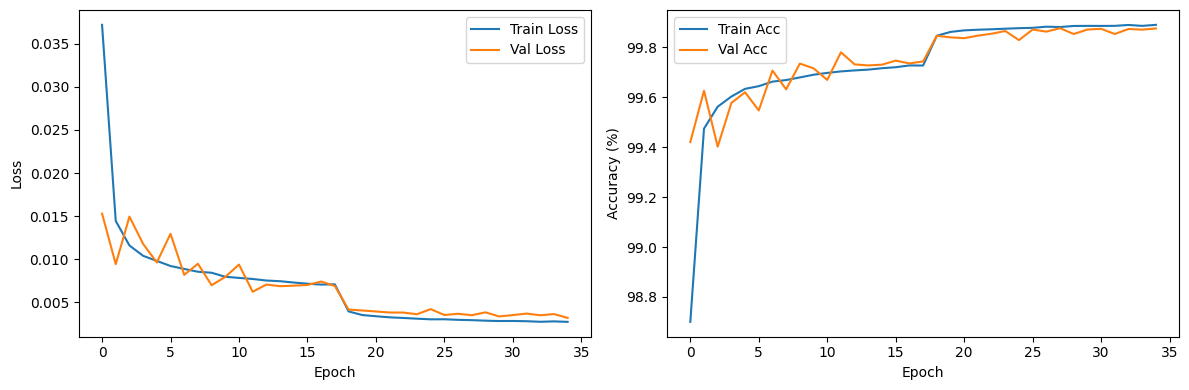


==== Confusion Matrix ====


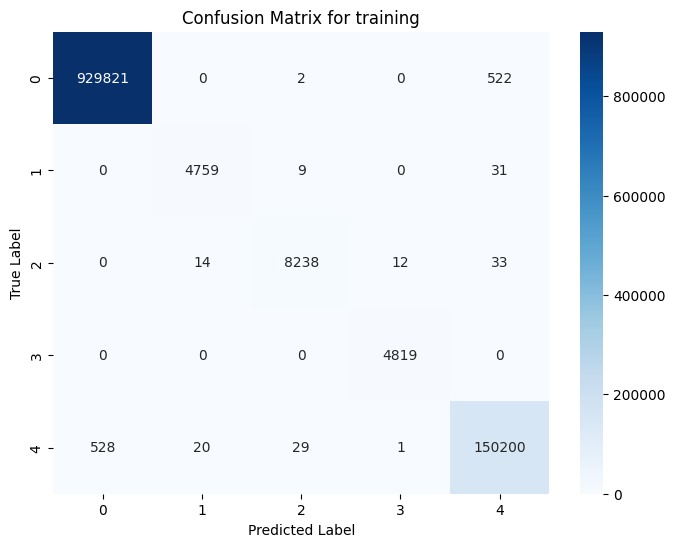

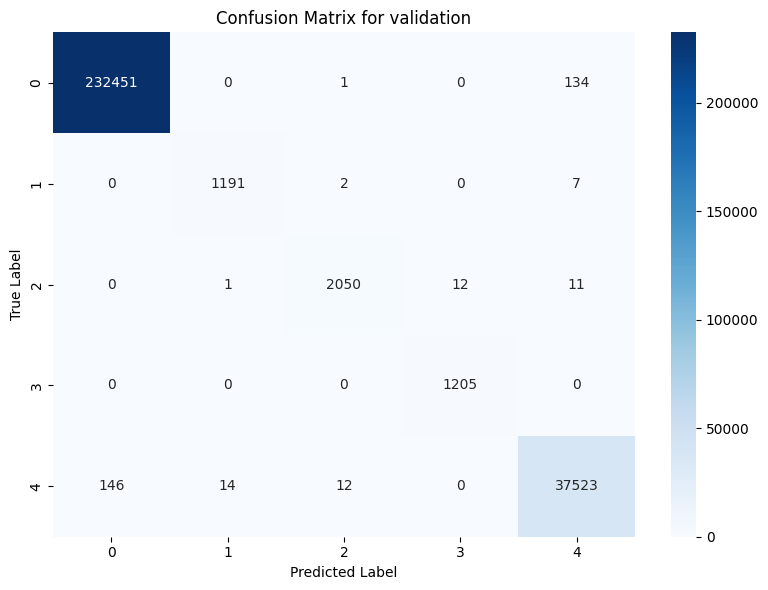

In [ ]:

# Training setup
train_loader, test_loader, scaler = preprocess_data(X, y)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = PVFaultClassifier().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5)

# Training parameters
num_epochs = 35
train_loader, test_loader, scaler = preprocess_data(X, y)

data, metrics = train_model(model, train_loader, test_loader, criterion, optimizer, num_epochs)
vizualize_training(metrics)
vizualize_confusion_matrix(data)


## L2 Regularization

Add L2 regularization with:
- weight decay on Adam optimization


Epoch [1/35]
Train Loss: 0.0524, Train Acc: 98.29%
Val Loss: 0.0411, Val Acc: 98.80%
Epoch [2/35]
Train Loss: 0.0343, Train Acc: 98.88%
Val Loss: 0.0332, Val Acc: 98.72%
Epoch [3/35]
Train Loss: 0.0317, Train Acc: 98.96%
Val Loss: 0.0289, Val Acc: 99.04%
Epoch [4/35]
Train Loss: 0.0309, Train Acc: 98.98%
Val Loss: 0.0279, Val Acc: 99.10%
Epoch [5/35]
Train Loss: 0.0301, Train Acc: 99.02%
Val Loss: 0.0286, Val Acc: 98.95%
Epoch [6/35]
Train Loss: 0.0292, Train Acc: 99.06%
Val Loss: 0.0295, Val Acc: 99.06%
Epoch [7/35]
Train Loss: 0.0284, Train Acc: 99.10%
Val Loss: 0.0292, Val Acc: 98.85%
Epoch [8/35]
Train Loss: 0.0281, Train Acc: 99.11%
Val Loss: 0.0297, Val Acc: 98.99%
Epoch [9/35]
Train Loss: 0.0281, Train Acc: 99.11%
Val Loss: 0.0275, Val Acc: 99.29%
Epoch [10/35]
Train Loss: 0.0279, Train Acc: 99.12%
Val Loss: 0.0254, Val Acc: 99.30%
Epoch [11/35]
Train Loss: 0.0278, Train Acc: 99.13%
Val Loss: 0.0322, Val Acc: 99.07%
Epoch [12/35]
Train Loss: 0.0277, Train Acc: 99.13%
Val Loss: 0

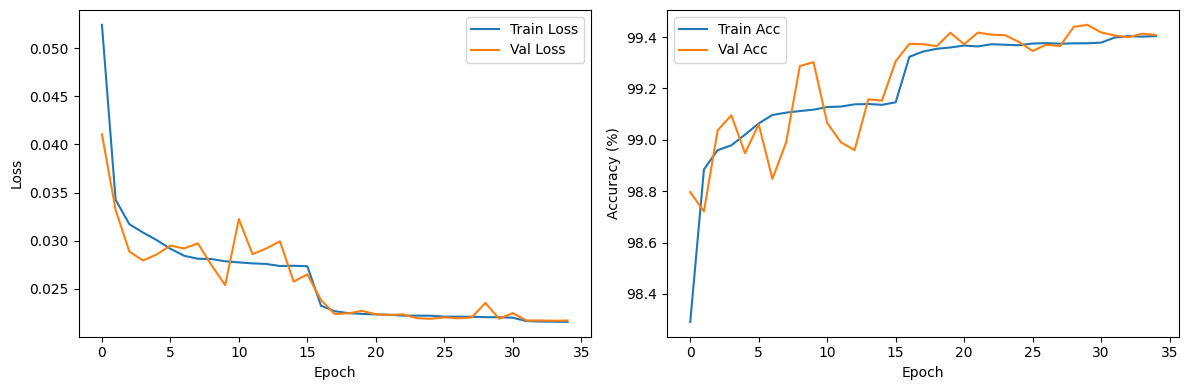


==== Confusion Matrix ====


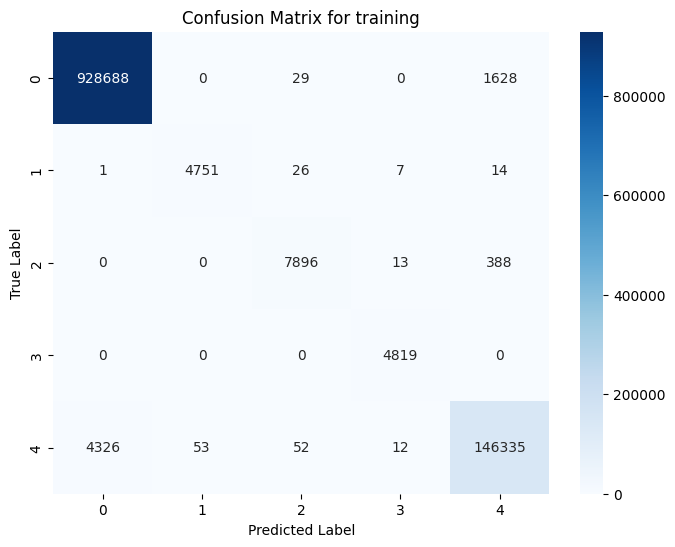

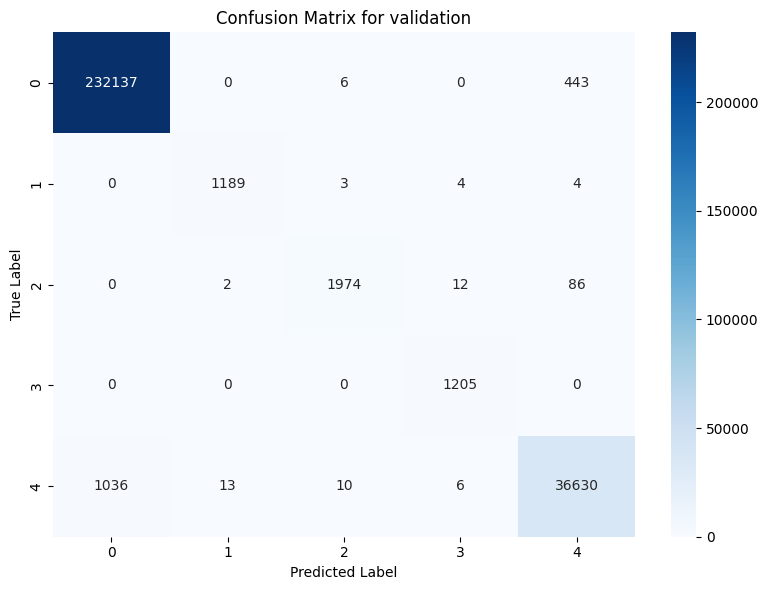

In [ ]:

# Training setup
train_loader, test_loader, scaler = preprocess_data(X, y)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = PVFaultClassifier().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=0.001)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5)

# Training parameters
num_epochs = 35
train_loader, test_loader, scaler = preprocess_data(X, y)

data, metrics = train_model(model, train_loader, test_loader, criterion, optimizer, num_epochs)
vizualize_training(metrics)
vizualize_confusion_matrix(data)

1. we first initialize the layers with random weights by creating model.
2. we then define the loss function func:
- input: [batch_size, n_classes), tensor or raw model outputs called (logits)
- target: [batch_size] tensor of class indices (0 to n_classes-1)
returns a single number representing average loss across the batch.
3. we create an Adam otpimizer object.

## Dropout regularization
Tries to reduce complex co-adaptations.

Epoch [1/35]
Train Loss: 0.0558, Train Acc: 98.06%
Val Loss: 0.0216, Val Acc: 99.24%
Epoch [2/35]
Train Loss: 0.0241, Train Acc: 99.17%
Val Loss: 0.0146, Val Acc: 99.44%
Epoch [3/35]
Train Loss: 0.0185, Train Acc: 99.35%
Val Loss: 0.0168, Val Acc: 99.48%
Epoch [4/35]
Train Loss: 0.0166, Train Acc: 99.42%
Val Loss: 0.0104, Val Acc: 99.63%
Epoch [5/35]
Train Loss: 0.0151, Train Acc: 99.47%
Val Loss: 0.0109, Val Acc: 99.61%
Epoch [6/35]
Train Loss: 0.0143, Train Acc: 99.50%
Val Loss: 0.0090, Val Acc: 99.67%
Epoch [7/35]
Train Loss: 0.0138, Train Acc: 99.52%
Val Loss: 0.0279, Val Acc: 98.93%
Epoch [8/35]
Train Loss: 0.0130, Train Acc: 99.55%
Val Loss: 0.0096, Val Acc: 99.67%
Epoch [9/35]
Train Loss: 0.0129, Train Acc: 99.56%
Val Loss: 0.0094, Val Acc: 99.66%
Epoch [10/35]
Train Loss: 0.0123, Train Acc: 99.57%
Val Loss: 0.0085, Val Acc: 99.70%
Epoch [11/35]
Train Loss: 0.0124, Train Acc: 99.59%
Val Loss: 0.0079, Val Acc: 99.69%
Epoch [12/35]
Train Loss: 0.0122, Train Acc: 99.58%
Val Loss: 0

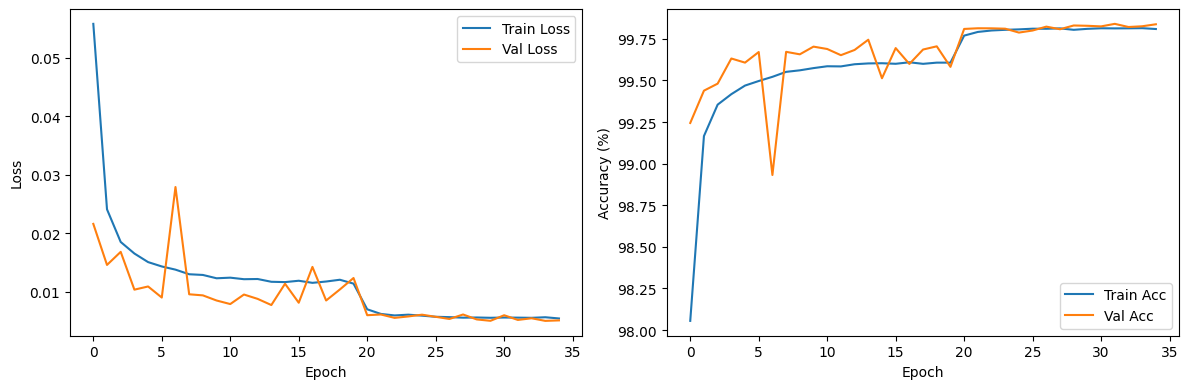


==== Confusion Matrix ====


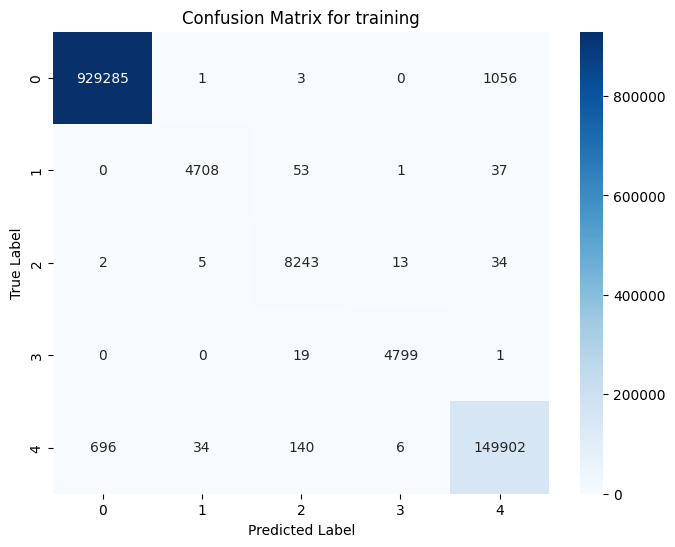

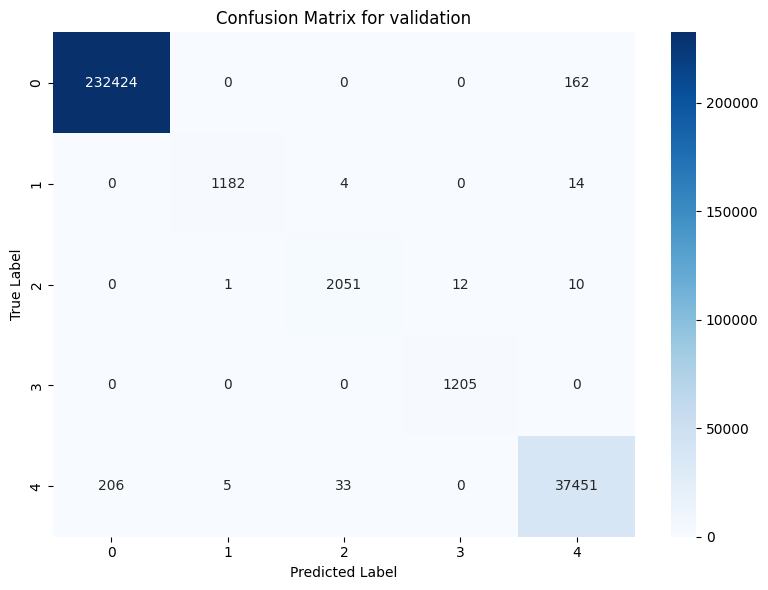

In [ ]:
class PVFaultClassifier_dropout(nn.Module):
  def __init__(self):
    super(PVFaultClassifier_dropout, self).__init__()
    self.model = nn.Sequential(
        nn.Conv1d(in_channels=1, out_channels=16, kernel_size=3, stride=1, padding=1),
        nn.ReLU(),
        nn.MaxPool1d(kernel_size=2),
        nn.Conv1d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1),
        nn.ReLU(),
        nn.MaxPool1d(kernel_size=2),
        nn.Flatten(),
        nn.Linear(32, 64),
        nn.ReLU(),
        nn.Dropout(0.5),
        nn.Linear(64, 5)
    )

  def forward(self, x):
    return self.model(x)

train_loader, test_loader, scaler = preprocess_data(X, y)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = PVFaultClassifier_dropout().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5)

# Training parameters
num_epochs = 35
train_loader, test_loader, scaler = preprocess_data(X, y)

data, metrics = train_model(model, train_loader, test_loader, criterion, optimizer, num_epochs)
vizualize_training(metrics)
vizualize_confusion_matrix(data)


# Class imbalance
- The following scripts will attempt to fix the class imbalance issue that we are facing.



## Using class weights
We compute the class weights using sklearn's compute class_weight.
The weights are calculated inversely to the class proportion.

```
y = [1, 1, 1, 1, 0, 0]
compute_class_weight(class_weight="balanced", classes=np.unique(y), y=y)
array([1.5 , 0.75])
```
The loss function takes into account the class imbalance.


Epoch [1/35]
Train Loss: 0.0829, Train Acc: 96.73%
Val Loss: 0.0491, Val Acc: 96.47%
Epoch [2/35]
Train Loss: 0.0306, Train Acc: 98.94%
Val Loss: 0.0323, Val Acc: 99.53%
Epoch [3/35]
Train Loss: 0.0258, Train Acc: 99.17%
Val Loss: 0.0221, Val Acc: 99.31%
Epoch [4/35]
Train Loss: 0.0226, Train Acc: 99.24%
Val Loss: 0.0293, Val Acc: 99.32%
Epoch [5/35]
Train Loss: 0.0215, Train Acc: 99.31%
Val Loss: 0.0200, Val Acc: 99.38%
Epoch [6/35]
Train Loss: 0.0213, Train Acc: 99.35%
Val Loss: 0.0164, Val Acc: 99.69%
Epoch [7/35]
Train Loss: 0.0215, Train Acc: 99.35%
Val Loss: 0.0194, Val Acc: 99.31%
Epoch [8/35]
Train Loss: 0.0209, Train Acc: 99.37%
Val Loss: 0.0194, Val Acc: 99.45%
Epoch [9/35]
Train Loss: 0.0186, Train Acc: 99.39%
Val Loss: 0.0187, Val Acc: 99.59%
Epoch [10/35]
Train Loss: 0.0204, Train Acc: 99.38%
Val Loss: 0.0224, Val Acc: 99.62%
Epoch [11/35]
Train Loss: 0.0204, Train Acc: 99.41%
Val Loss: 0.0197, Val Acc: 99.55%
Epoch [12/35]
Train Loss: 0.0194, Train Acc: 99.42%
Val Loss: 0

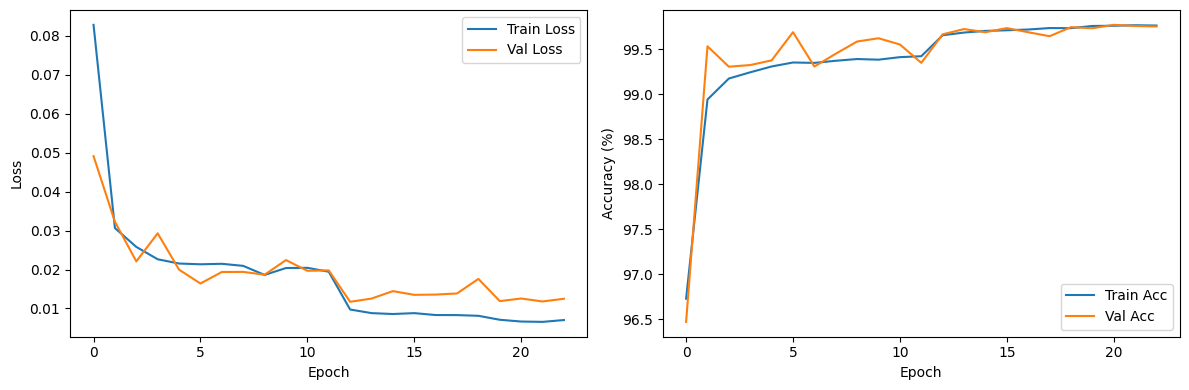


==== Confusion Matrix ====


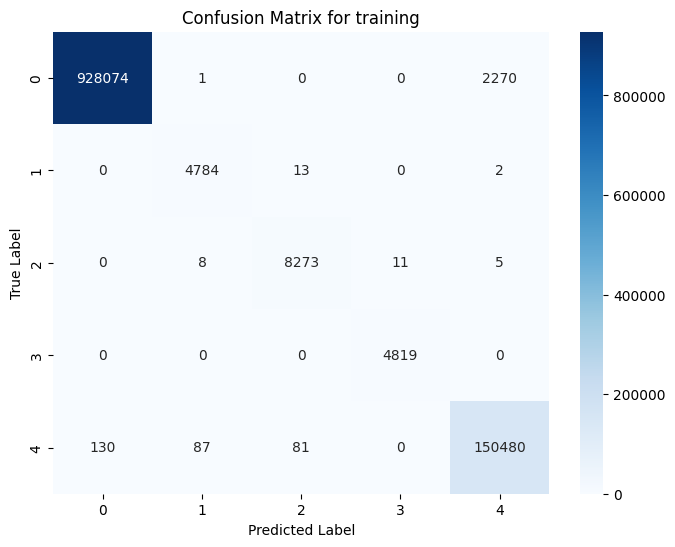

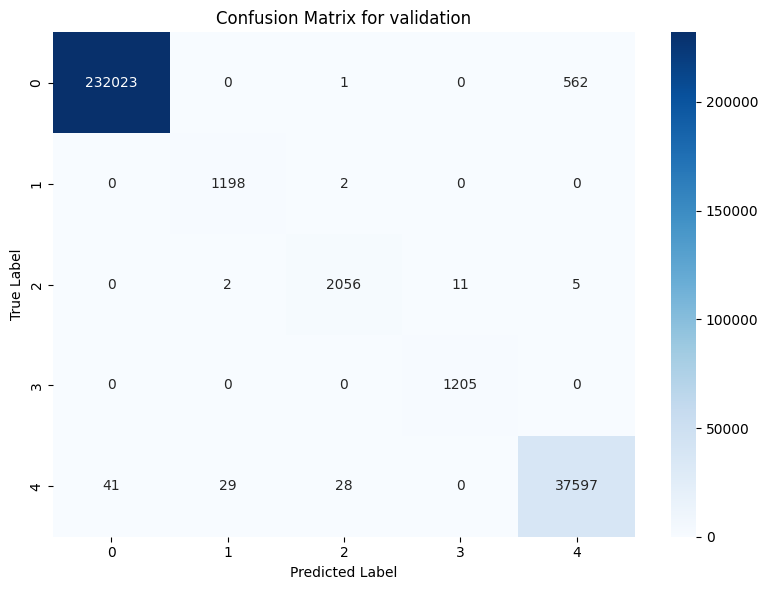

In [ ]:
from sklearn.utils.class_weight import compute_class_weight

import torch.nn as nn

train_loader, test_loader, scaler = preprocess_data(X, y)
train_dataset_labels = train_loader.dataset.y.numpy()

class_weights = compute_class_weight('balanced', classes=np.unique(train_dataset_labels), y=train_dataset_labels)
class_weights = torch.tensor(class_weights, dtype=torch.float)

# Training setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = PVFaultClassifier().to(device)
criterion = nn.CrossEntropyLoss(weight=class_weights.to(device))
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5)
# Training parameters

num_epochs = 35
train_loader, test_loader, scaler = preprocess_data(X, y)
data, metrics = train_model(model, train_loader, test_loader, criterion, optimizer, num_epochs)
vizualize_training(metrics)
vizualize_confusion_matrix(data)



## :Combining L2, weight distrib, neuron on and Off and

Epoch [1/35]
Train Loss: 0.2074, Train Acc: 92.61%
Val Loss: 0.1227, Val Acc: 96.02%
Epoch [2/35]
Train Loss: 0.1553, Train Acc: 94.32%
Val Loss: 0.1482, Val Acc: 96.69%
Epoch [3/35]
Train Loss: 0.1520, Train Acc: 94.42%
Val Loss: 0.1179, Val Acc: 95.20%
Epoch [4/35]
Train Loss: 0.1488, Train Acc: 94.50%
Val Loss: 0.1270, Val Acc: 95.69%
Epoch [5/35]
Train Loss: 0.1483, Train Acc: 94.46%
Val Loss: 0.1212, Val Acc: 95.81%
Epoch [6/35]
Train Loss: 0.1483, Train Acc: 94.50%
Val Loss: 0.1214, Val Acc: 93.94%
Epoch [7/35]
Train Loss: 0.1475, Train Acc: 94.47%
Val Loss: 0.1230, Val Acc: 95.63%
Epoch [8/35]
Train Loss: 0.1486, Train Acc: 94.51%
Val Loss: 0.1229, Val Acc: 95.98%
Epoch [9/35]
Train Loss: 0.1483, Train Acc: 94.45%
Val Loss: 0.1322, Val Acc: 93.55%
Epoch [10/35]
Train Loss: 0.1363, Train Acc: 94.87%
Val Loss: 0.1167, Val Acc: 95.20%
Epoch [11/35]
Train Loss: 0.1368, Train Acc: 94.95%
Val Loss: 0.1166, Val Acc: 95.66%
Epoch [12/35]
Train Loss: 0.1372, Train Acc: 94.96%
Val Loss: 0

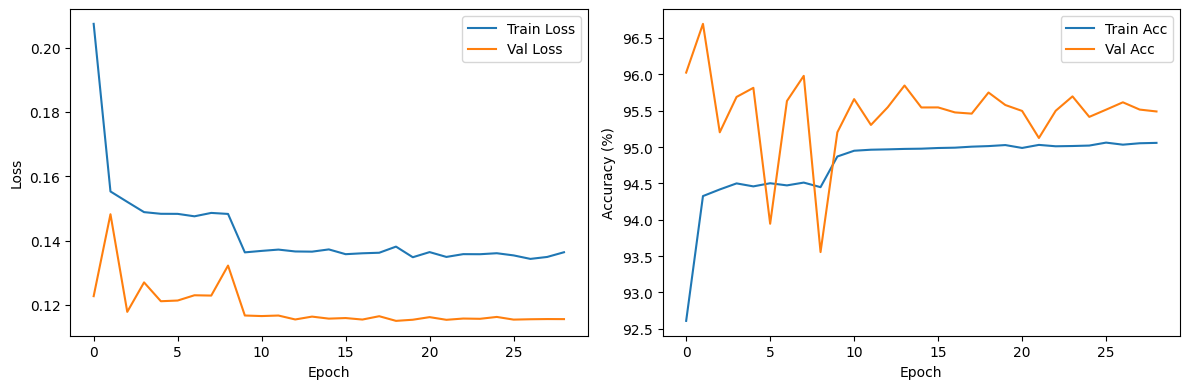


==== Confusion Matrix ====


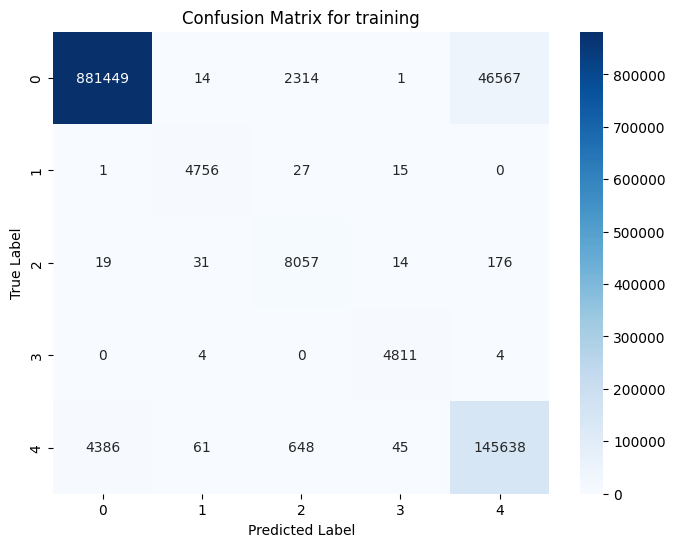

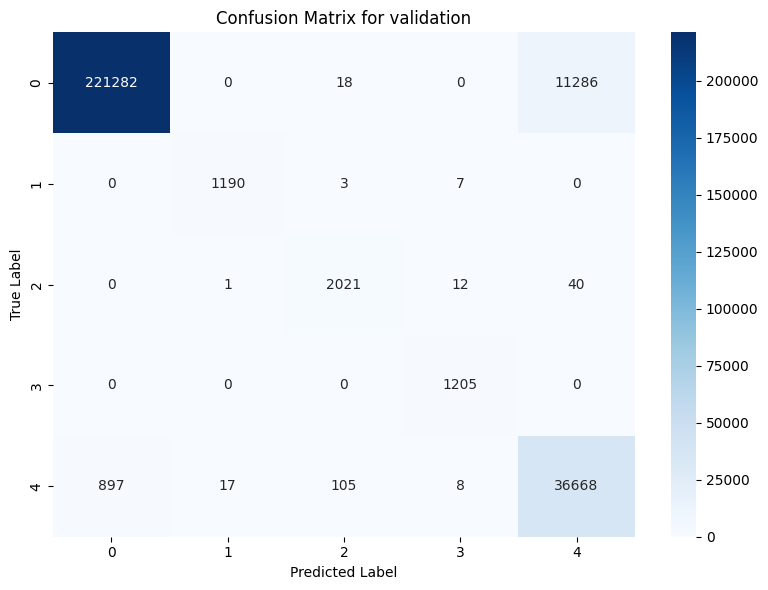

In [ ]:
from sklearn.utils.class_weight import compute_class_weight

import torch.nn as nn
class PVFaultClassifier_dropout(nn.Module):
  def __init__(self):
    super(PVFaultClassifier_dropout, self).__init__()
    self.model = nn.Sequential(
        nn.Conv1d(in_channels=1, out_channels=16, kernel_size=3, stride=1, padding=1),
        nn.ReLU(),
        nn.MaxPool1d(kernel_size=2),
        nn.Conv1d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1),
        nn.ReLU(),
        nn.MaxPool1d(kernel_size=2),
        nn.Flatten(),
        nn.Linear(32, 64),
        nn.ReLU(),
        nn.Dropout(0.5),
        nn.Linear(64, 5)
    )

  def forward(self, x):
    return self.model(x)

train_loader, test_loader, scaler = preprocess_data(X, y)
train_dataset_labels = train_loader.dataset.y.numpy()

class_weights = compute_class_weight('balanced', classes=np.unique(train_dataset_labels), y=train_dataset_labels)
class_weights = torch.tensor(class_weights, dtype=torch.float)

# Training setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = PVFaultClassifier_dropout().to(device)
criterion = nn.CrossEntropyLoss(weight=class_weights.to(device))
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay= 0.01)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5)
# Training parameters

num_epochs = 35
train_loader, test_loader, scaler = preprocess_data(X, y)
data, metrics = train_model(model, train_loader, test_loader, criterion, optimizer, num_epochs)
vizualize_training(metrics)
vizualize_confusion_matrix(data)



## Sampling the same amount for each class

my guess is:

input some NEW DATA (THE BALANCED DATA) INTO THE PREPROCESS DATA. FOR THIS, I NEED TO MAKE MY X AND Y DATA BE DOWN SAMPLED, NOT THE TRAIN_LOADER.Y


[1162931    5999   10371    6024  188473]
Epoch [1/35]
Train Loss: 0.3827, Train Acc: 85.83%
Val Loss: 0.3441, Val Acc: 84.76%
Epoch [2/35]
Train Loss: 0.1029, Train Acc: 96.53%
Val Loss: 0.1494, Val Acc: 94.43%
Epoch [3/35]
Train Loss: 0.0732, Train Acc: 97.72%
Val Loss: 0.1042, Val Acc: 95.89%
Epoch [4/35]
Train Loss: 0.0623, Train Acc: 97.91%
Val Loss: 0.0950, Val Acc: 96.09%
Epoch [5/35]
Train Loss: 0.0562, Train Acc: 98.13%
Val Loss: 0.2055, Val Acc: 92.03%
Epoch [6/35]
Train Loss: 0.0550, Train Acc: 98.07%
Val Loss: 0.0790, Val Acc: 96.58%
Epoch [7/35]
Train Loss: 0.0505, Train Acc: 98.24%
Val Loss: 0.1093, Val Acc: 95.02%
Epoch [8/35]
Train Loss: 0.0488, Train Acc: 98.31%
Val Loss: 0.0799, Val Acc: 96.76%
Epoch [9/35]
Train Loss: 0.0472, Train Acc: 98.36%
Val Loss: 0.0817, Val Acc: 96.03%
Epoch [10/35]
Train Loss: 0.0454, Train Acc: 98.37%
Val Loss: 0.0757, Val Acc: 96.61%
Epoch [11/35]
Train Loss: 0.0426, Train Acc: 98.53%
Val Loss: 0.0748, Val Acc: 96.63%
Epoch [12/35]
Train L

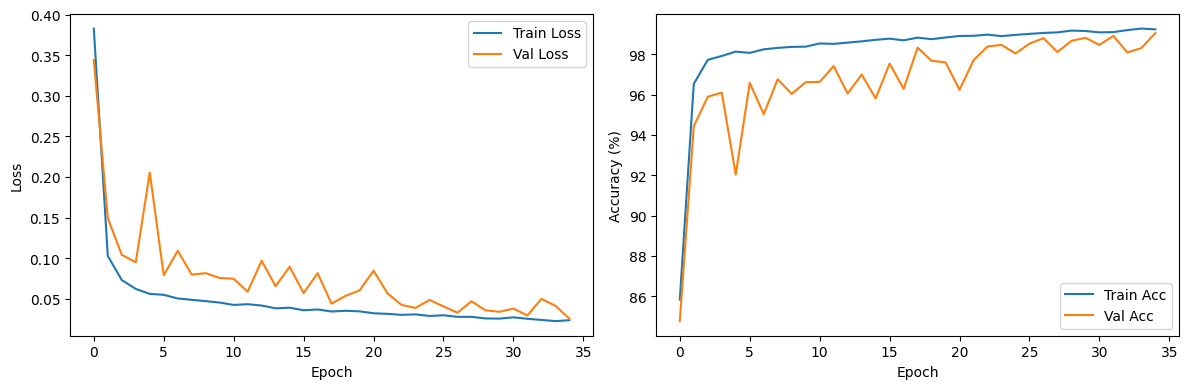


==== Confusion Matrix ====


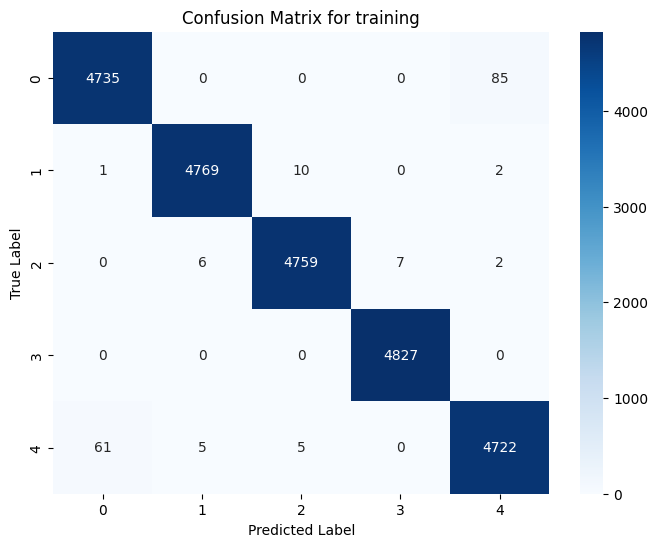

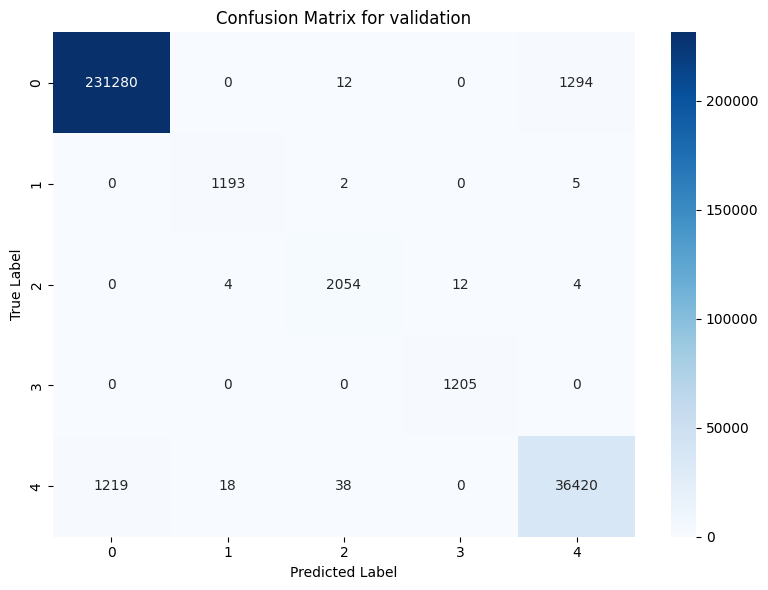

In [ ]:
from sklearn.utils import resample

class_counts = np.unique(y, return_counts=True)[1]
print(class_counts)
min_count = np.min(class_counts)

#Subsample the majority classes to match the size of the minority class


def preprocess_data_subsample(X, y):
    X_train_balanced = []
    y_train_balanced = []

    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    for i in np.unique(y):
        # Use boolean indexing to extract, use values.ravel() to match the dimensions.
        mask = y.values.ravel() == i
        #print("mask shape:", mask.shape, "mask:", mask)
        X_class = X_scaled[mask]
        y_class = y[mask]
        X_class_resampled, y_class_resampled = resample(X_class, y_class, n_samples=min_count, random_state=18)
        X_train_balanced.append(X_class_resampled)
        y_train_balanced.append(y_class_resampled)
        # transform list back into (1373798, 6) (1373798, 1) respectively
    X_trained_balanced = np.concatenate(X_train_balanced)
    y_trained_balanced = np.concatenate(y_train_balanced)

    X_train, X_test, y_train, y_test = train_test_split(X_trained_balanced, y_trained_balanced, test_size=0.2, random_state=42)

    train_dataset = PVFaultDataset(X_train, y_train)
    test_dataset = PVFaultDataset(X_test, y_test)

    train_loader = DataLoader(train_dataset, batch_size=32, num_workers=2, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=32, num_workers=2, shuffle=False)



    return train_loader, test_loader, scaler


# Training setup with NO L2 REGULARIZATION
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = PVFaultClassifier().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5)

# Training parameters
num_epochs = 35

balanced_train_loader, balanced_test_loader, scaler = preprocess_data_subsample(X, y)
train_loader, test_loader, scaler = preprocess_data(X, y)

data, metrics = train_model(model, balanced_train_loader, test_loader, criterion, optimizer, num_epochs)
vizualize_training(metrics)
vizualize_confusion_matrix(data)

# K fold cross validation

WE DONT USE THE TRAIN TEST SPLIT

need to think this thry

Implement k fold cross validation

In [ ]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
import torch

def preprocess_data_kfold(X, y):
    # Normalize data
    scaler = StandardScaler()
    # transform X data into numpy array. Remember we are only doing this to X, not y
    X_scaled = scaler.fit_transform(X)

    #Split in kfold

    skf = StratifiedKFold(n_splits=5, shuffle = True, random_state=42)
    fold_loaders = []
    for fold, (train_idx, val_idx) in enumerate(skf.split(X_scaled, y)):
        X_train, X_val = X_scaled[train_idx], X_scaled[val_idx]
        y_train, y_val = y.values[train_idx], y.values[val_idx]

        # Create datasets
        train_dataset = PVFaultDataset(X_train, y_train)
        test_dataset = PVFaultDataset(X_val, y_val)
        # Create data loaders
        train_loader = DataLoader(train_dataset, batch_size=32, num_workers=2, shuffle=True)
        test_loader = DataLoader(test_dataset, batch_size=32, num_workers=2, shuffle=False)
        # append to fold loader
        fold_loaders.append((train_loader, test_loader, scaler))

    return fold_loaders, scaler

Training Fold 1
Epoch [1/10]
Train Loss: 0.1358, Train Acc: 94.43%
Val Loss: 0.0787, Val Acc: 95.61%
Epoch [2/10]
Train Loss: 0.0723, Train Acc: 96.90%
Val Loss: 0.0420, Val Acc: 98.76%
Epoch [3/10]
Train Loss: 0.0662, Train Acc: 97.18%
Val Loss: 0.0538, Val Acc: 96.94%
Epoch [4/10]
Train Loss: 0.0626, Train Acc: 97.22%
Val Loss: 0.0479, Val Acc: 97.39%
Epoch [5/10]
Train Loss: 0.0625, Train Acc: 97.27%
Val Loss: 0.0517, Val Acc: 96.96%
Epoch [6/10]
Train Loss: 0.0591, Train Acc: 97.34%
Val Loss: 0.0396, Val Acc: 98.76%
Epoch [7/10]
Train Loss: 0.0591, Train Acc: 97.38%
Val Loss: 0.0396, Val Acc: 97.95%
Epoch [8/10]
Train Loss: 0.0573, Train Acc: 97.38%
Val Loss: 0.0620, Val Acc: 96.60%
Epoch [9/10]
Train Loss: 0.0562, Train Acc: 97.41%
Val Loss: 0.0397, Val Acc: 97.76%
Epoch [10/10]
Train Loss: 0.0561, Train Acc: 97.45%
Val Loss: 0.0401, Val Acc: 97.81%
Training Fold 2
Epoch [1/10]
Train Loss: 0.0571, Train Acc: 97.46%
Val Loss: 0.0401, Val Acc: 97.91%
Epoch [2/10]
Train Loss: 0.0564,

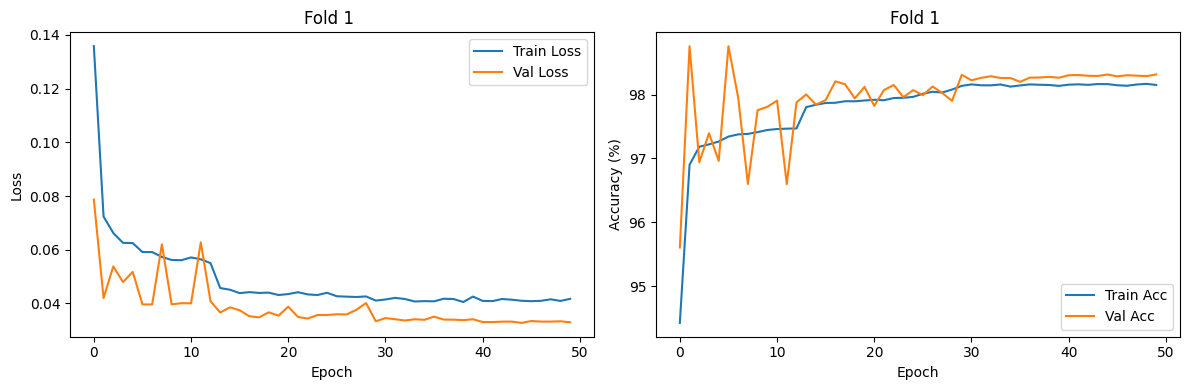

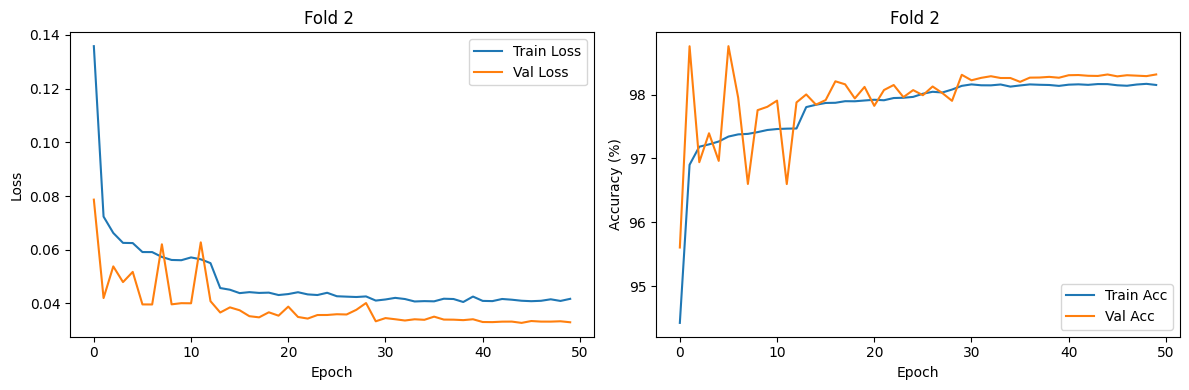

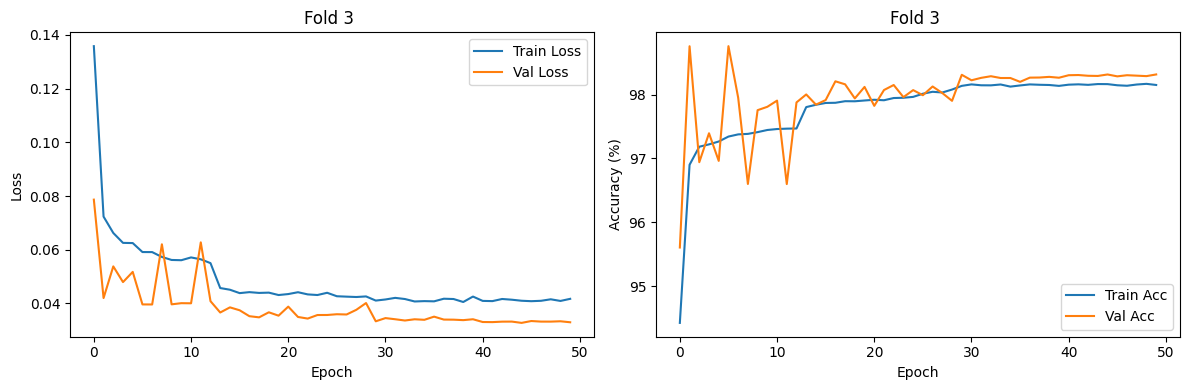

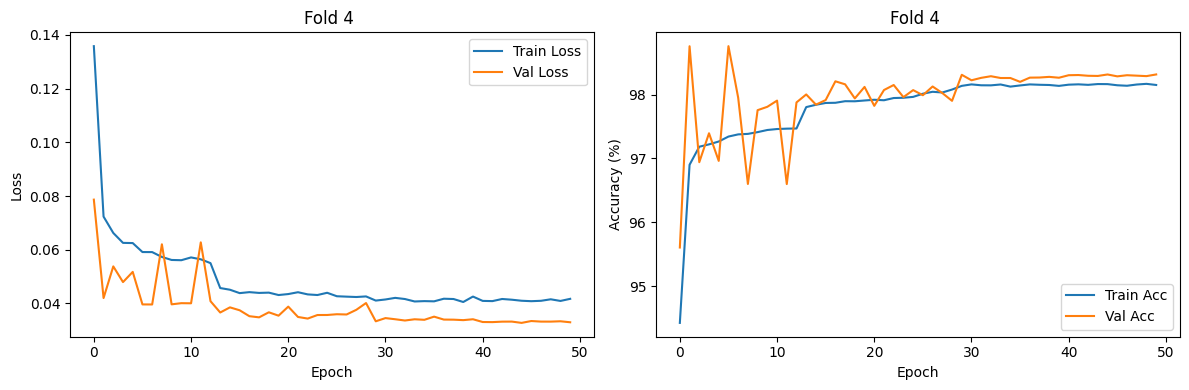

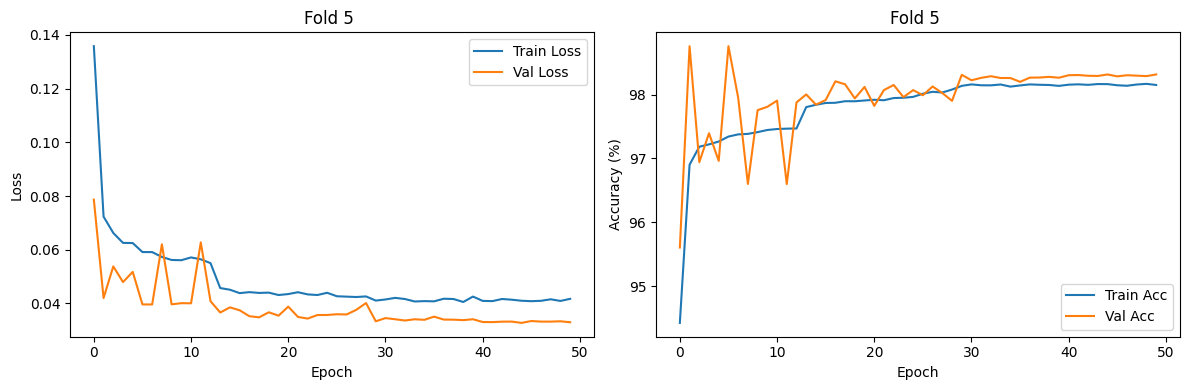


==== Confusion Matrix ====


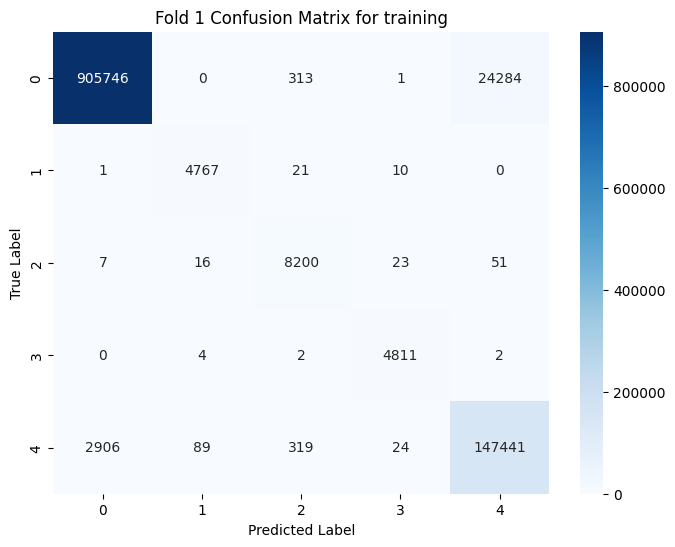

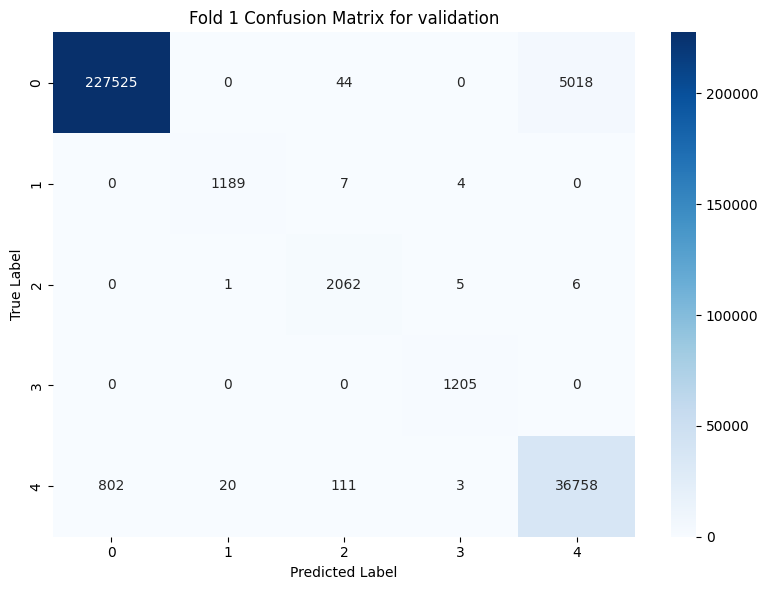


==== Confusion Matrix ====


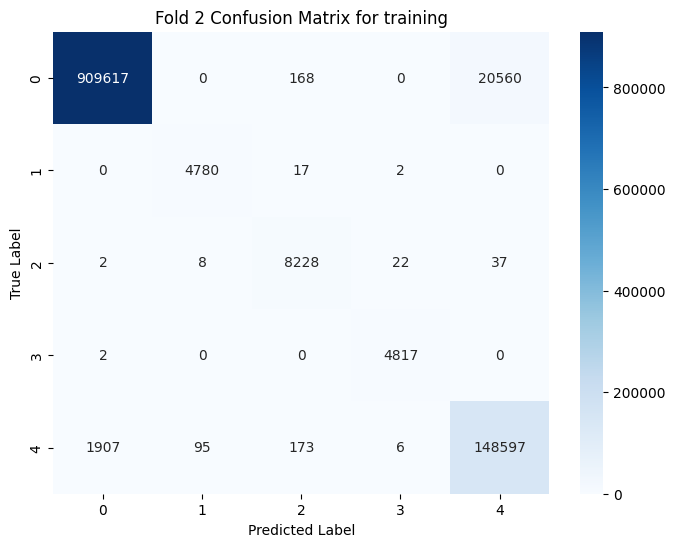

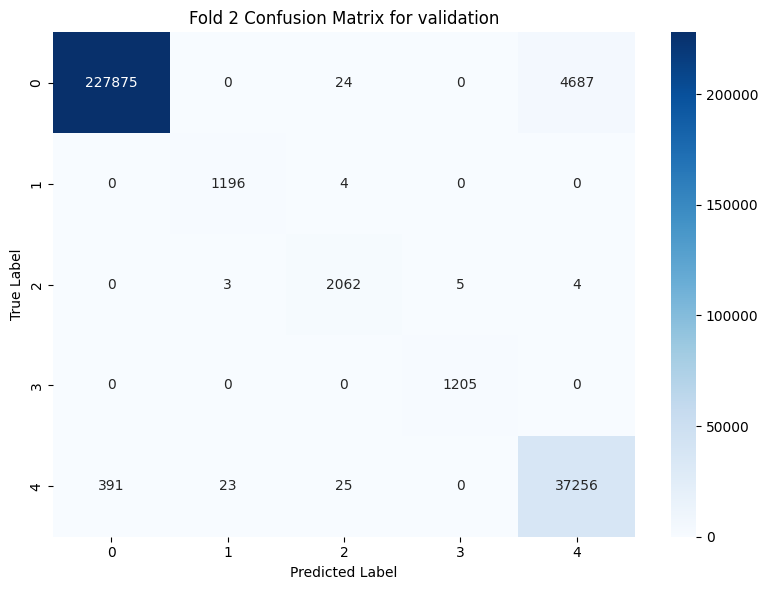


==== Confusion Matrix ====


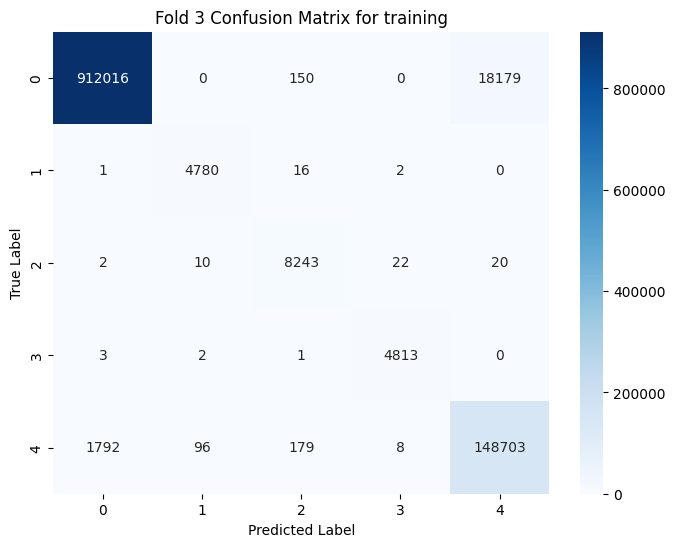

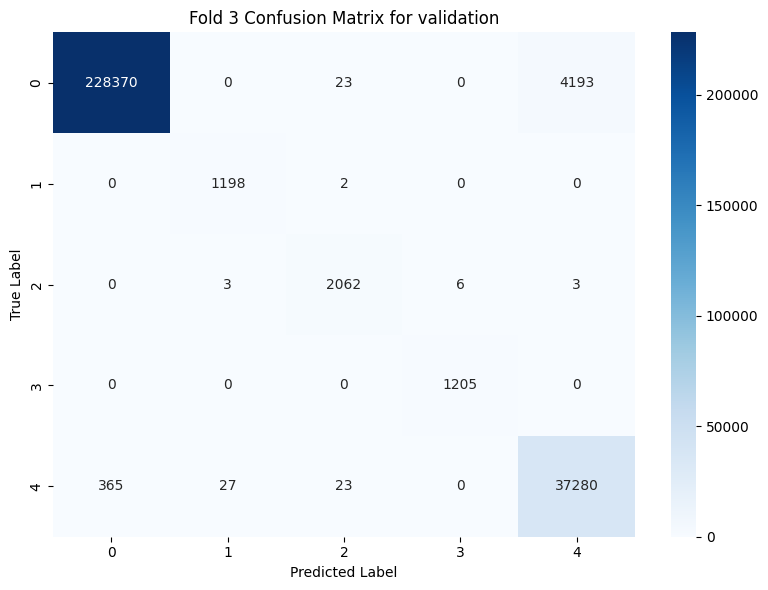


==== Confusion Matrix ====


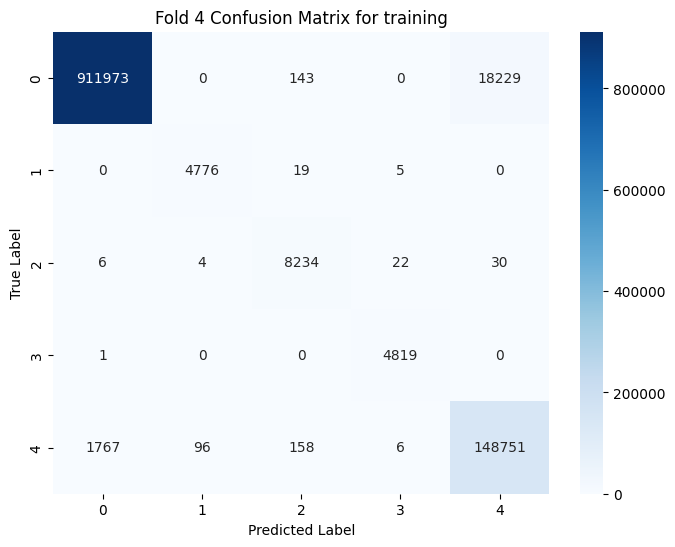

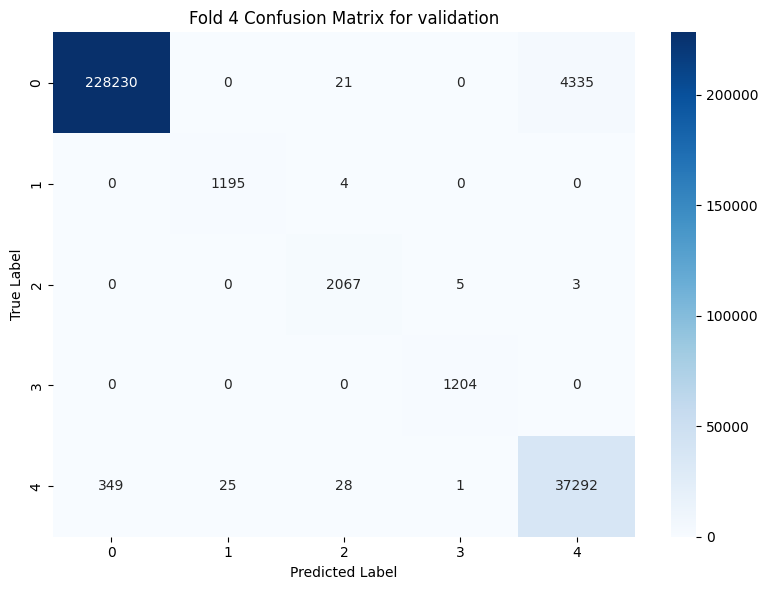


==== Confusion Matrix ====


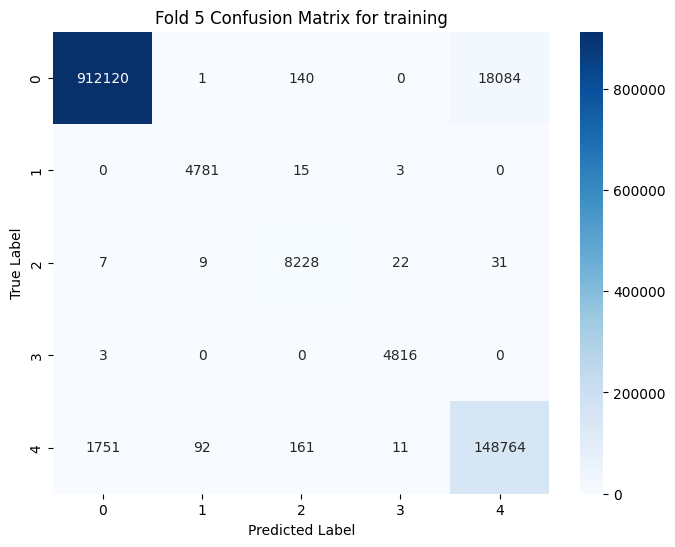

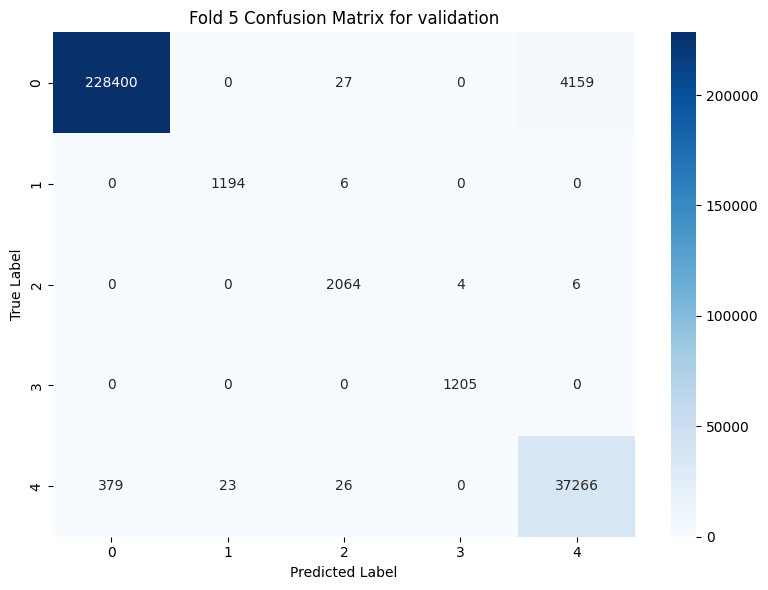

In [ ]:
from sklearn.utils import resample
from sklearn.model_selection import KFold
from sklearn.utils import resample
from sklearn.model_selection import StratifiedKFold

def train_kfold(model, fold_loaders, criterion, optimizer, num_epochs):
    #storing results
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []
    all_fold_metrics = []
    all_fold_data = []
    best_val_loss = float('inf')
    patience = 10  # Early stopping patience
    patience_counter = 0
    for fold, (train_loader, test_loader, scaler) in enumerate(fold_loaders):
        print(f"Training Fold {fold + 1}")

        for epoch in range(num_epochs):
            train_loss, train_acc, pred_train, target_train = train_one_epoch(model, train_loader, criterion, optimizer)
            val_loss, val_acc, pred_val, target_val = validate(model, test_loader, criterion)

            train_losses.append(train_loss)
            val_losses.append(val_loss)
            train_accuracies.append(train_acc)
            val_accuracies.append(val_acc)

            print(f'Epoch [{epoch+1}/{num_epochs}]')
            print(f'Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%')
            print(f'Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%')

            scheduler.step(val_loss)


            if val_loss < best_val_loss:
                best_val_loss = val_loss
                torch.save(model.state_dict(), 'best_model.pth')
                patience_counter = 0
            else:
                patience_counter += 1
                if patience_counter >= patience:
                    print("Early stopping triggered")
                    break

        fold_data = {
            'pred_train': pred_train,
            'target_train': target_train,
            'pred_val': pred_val,
            'target_val': target_val,
        }

        fold_metrics = {
            'train_losses': train_losses,
            'val_losses': val_losses,
            'train_accuracies': train_accuracies,
            'val_accuracies': val_accuracies
        }

        all_fold_metrics.append(fold_metrics)
        all_fold_data.append(fold_data)

    return all_fold_metrics, all_fold_data, scaler

def vizualize_kfold_training(fold_metrics):
    for fold, metrics in enumerate(fold_metrics):
        plt.figure(figsize=(12, 4))
        plt.subplot(1, 2, 1)
        plt.title(f'Fold {fold + 1} ')
        plt.plot(metrics['train_losses'], label='Train Loss')
        plt.plot(metrics['val_losses'], label='Val Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()

        plt.subplot(1, 2, 2)
        plt.title(f'Fold {fold + 1} ')
        plt.plot(metrics['train_accuracies'], label='Train Acc')
        plt.plot(metrics['val_accuracies'], label='Val Acc')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy (%)')
        plt.legend()

        plt.tight_layout()
        plt.show()

def vizualize_kfold_confusion_matrix(fold_data):
    for fold, data in enumerate(fold_data):
        pred_train = data['pred_train']
        target_train = data['target_train']
        pred_val = data['pred_val']
        target_val = data['target_val']
        print("\n==== Confusion Matrix ====")
        cm_train = confusion_matrix(target_train, pred_train)
        cm_val = confusion_matrix(target_val, pred_val)
        plt.figure(figsize=(8, 6))
        sns.heatmap(cm_train, annot=True, fmt='d', cmap='Blues')
        plt.title(f'Fold {fold + 1} Confusion Matrix for training')
        plt.ylabel('True Label')
        plt.xlabel('Predicted Label')

        plt.figure(figsize=(8, 6))
        sns.heatmap(cm_val, annot=True, fmt='d', cmap='Blues')
        plt.title(f'Fold {fold + 1} Confusion Matrix for validation')
        plt.ylabel('True Label')
        plt.xlabel('Predicted Label')

        plt.tight_layout()
        plt.show()

fold_loaders, scaler = preprocess_data_kfold(X, y)

class_weights = compute_class_weight('balanced', classes=np.unique(train_dataset_labels), y=train_dataset_labels)
class_weights = torch.tensor(class_weights, dtype=torch.float)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = PVFaultClassifier_dropout().to(device)
criterion = nn.CrossEntropyLoss(weight=class_weights.to(device))
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=0.001)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5)
# Training parameters
num_epochs = 10


fold_metrics, fold_data, scaler = train_kfold(model, fold_loaders, criterion, optimizer, num_epochs)
vizualize_kfold_training(fold_metrics)
vizualize_kfold_confusion_matrix(fold_data)


In [ ]:
from sklearn.model_selection import train_test_split

def prepare_data_splits(X, y, test_size=0.15, val_size=0.15):
    # First split: separate test set
    X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=test_size, random_state=42)

    # Second split: separate validation set
    val_size_adjusted = val_size / (1 - test_size)  # Adjust validation size
    X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp,
                                                      test_size=val_size_adjusted,
                                                      random_state=42)
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_val = scaler.transform(X_val)
    X_test = scaler.transform(X_test)

    train_dataset = PVFaultDataset(X_train, y_train)
    val_dataset = PVFaultDataset(X_val, y_val)
    test_dataset = PVFaultDataset(X_test, y_test)

    train_loader = DataLoader(train_dataset, batch_size=32, num_workers=2, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=32, num_workers=2, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=32, num_workers=2, shuffle=False)

    return X_train, X_val, X_test, y_train, y_val, y_test




0.15
0.17647058823529413


In [ ]:
import itertools
from sklearn.model_selection import train_test_split
import torch.optim as optim
from collections import defaultdict

from sklearn.model_selection import train_test_split

def prepare_data_splits(X, y, test_size, val_size):
    # First split: separate test set
    X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=test_size, random_state=42)

    # Second split: separate validation set
    val_size_adjusted = val_size / (1 - test_size)  # Adjust validation size
    X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp,
                                                      test_size=val_size_adjusted,
                                                      random_state=42)
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_val = scaler.transform(X_val)
    X_test = scaler.transform(X_test)

    train_dataset = PVFaultDataset(X_train, y_train)
    val_dataset = PVFaultDataset(X_val, y_val)
    test_dataset = PVFaultDataset(X_test, y_test)

    train_loader = DataLoader(train_dataset, batch_size=32, num_workers=2, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=32, num_workers=2, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=32, num_workers=2, shuffle=False)

    return train_loader, val_loader, test_loader, scaler



class PVFaultClassifier(nn.Module):
    def __init__(self, conv1_channels=16, conv2_channels=32,
                 fc1_size=64, dropout_rate=0.3):
        super(PVFaultClassifier, self).__init__()

        # First convolutional block
        self.conv1 = nn.Conv1d(in_channels=1, out_channels=conv1_channels,
                              kernel_size=3, stride=1, padding=1)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool1d(kernel_size=2)
        self.dropout1 = nn.Dropout(dropout_rate)

        # Second convolutional block
        self.conv2 = nn.Conv1d(in_channels=conv1_channels,
                              out_channels=conv2_channels,
                              kernel_size=3, stride=1, padding=1)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool1d(kernel_size=2)
        self.dropout2 = nn.Dropout(dropout_rate)

        # Fully connected layers
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(conv2_channels, fc1_size)
        self.relu3 = nn.ReLU()
        self.dropout3 = nn.Dropout(dropout_rate)
        self.fc2 = nn.Linear(fc1_size, 5)

    def forward(self, x):
        # First conv block
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.pool1(x)
        x = self.dropout1(x)

        # Second conv block
        x = self.conv2(x)
        x = self.relu2(x)
        x = self.pool2(x)
        x = self.dropout2(x)

        # Fully connected layers
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.relu3(x)
        x = self.dropout3(x)
        x = self.fc2(x)

        return x

class ModelValidator:
    def __init__(self, X, y, test_size=0.15, val_size=0.15):
        # Split data into train, validation, and test sets

        self.train_loader, self.validate_loader, self.test_loader = prepare_data_splits(X, y, test_size, val_size)

        # Configuration space
        self.config_space = {
            'conv1_channels': [16, 32, 64],
            'conv2_channels': [32, 64, 128],
            'fc1_size': [64, 128, 256],
            'dropout_rate': [0.2, 0.3, 0.4],
            'learning_rate': [0.001, 0.0001],
            'weight_decay': [0.0001, 0.001, 0.01]
        }

        self.results = defaultdict(list)

    def train_and_validate_configuration(self, config, num_epochs=35):
        """Train and validate a single configuration"""
        # Create model with current configuration
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

        model = PVFaultClassifier(
            conv1_channels=config['conv1_channels'],
            conv2_channels=config['conv2_channels'],
            fc1_size=config['fc1_size'],
            dropout_rate=config['dropout_rate']
        ).to(device)

        # Setup training
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.Adam(
            model.parameters(),
            lr=config['learning_rate'],
            weight_decay=config['weight_decay']
        )
        scheduler = optim.lr_scheduler.ReduceLROnPlateau(
            optimizer, mode='min', factor=0.1, patience=5
        )

        # Training loop
        best_val_acc = 0
        patience_counter = 0
        patience = 10

        for epoch in range(num_epochs):
            # Train
            train_loss, train_acc = train_one_epoch(
                model, self.train_loader, criterion, optimizer
            )

            # Validate
            val_loss, val_acc = validate(model, self.val_loader, criterion)

            # Learning rate scheduling
            scheduler.step(val_loss)

            # Early stopping
            if val_acc > best_val_acc:
                best_val_acc = val_acc
                best_model_state = model.state_dict()
                patience_counter = 0
            else:
                patience_counter += 1
                if patience_counter >= patience:
                    break

        return best_val_acc, best_model_state

    def grid_search(self, num_trials=3):
        """Perform grid search over configuration space"""
        # Generate all possible combinations
        keys = self.config_space.keys()
        values = self.config_space.values()
        configurations = [dict(zip(keys, v)) for v in itertools.product(*values)]

        best_config = None
        best_accuracy = 0

        for config in configurations:
            print(f"\nTesting configuration: {config}")

            # Run multiple trials for each configuration
            trial_accuracies = []
            for trial in range(num_trials):
                print(f"Trial {trial + 1}/{num_trials}")
                val_acc, _ = self.train_and_validate_configuration(config)
                trial_accuracies.append(val_acc)

            # Store results
            mean_acc = np.mean(trial_accuracies)
            std_acc = np.std(trial_accuracies)
            self.results['config'].append(config)
            self.results['mean_acc'].append(mean_acc)
            self.results['std_acc'].append(std_acc)

            print(f"Mean validation accuracy: {mean_acc:.2f}% (±{std_acc:.2f})")

            # Update best configuration
            if mean_acc > best_accuracy:
                best_accuracy = mean_acc
                best_config = config

        return best_config, self.results

    def train_final_model(self, best_config):

        # Create and train model
        final_model = PVFaultClassifier(**best_config).to(device)
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.Adam(
            final_model.parameters(),
            lr=best_config['learning_rate'],
            weight_decay=best_config['weight_decay']
        )

        # Train model
        final_accuracy = self.train_and_validate_configuration(best_config)

        return final_model, final_accuracy


# Visualize results
def plot_results(results):
    configs = results['config']
    accuracies = results['mean_acc']
    std_devs = results['std_acc']

    plt.figure(figsize=(12, 6))
    plt.errorbar(range(len(configs)), accuracies, yerr=std_devs, fmt='o')
    plt.xlabel('Configuration Index')
    plt.ylabel('Validation Accuracy (%)')
    plt.title('Hyperparameter Search Results')
    plt.grid(True)
    plt.show()


# Initialize validator
validator = ModelValidator(X, y)

# Run grid search
best_config, results = validator.grid_search(num_trials=3)
print(f"Best configuration found: {best_config}")

# Train final model
final_model, final_accuracy = validator.train_final_model(best_config)
print(f"Final test accuracy: {final_accuracy:.2f}%")

# Visualize results
plot_results(results)


Testing configuration: {'conv1_channels': 16, 'conv2_channels': 32, 'fc1_size': 64, 'dropout_rate': 0.2, 'learning_rate': 0.001, 'weight_decay': 0.0001}
Trial 1/3


AttributeError: 'ModelValidator' object has no attribute 'prepare_data_splits'

Add more overfitting proof code (nn.Dropout) and then push to github
